In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel


print("Loading and Engineering Data...")
# Đọc từ file gốc 'weather_data_danang.csv' vì file 'preprocessed_data.csv' đã bị xoá mất cột Time
data = pd.read_csv('weather_data_danang.csv')

# --- A. FEATURE ENGINEERING (TẠO ĐẶC TRƯNG MỚI) ---
data['time'] = pd.to_datetime(data['time'])
data = data.sort_values('time')

# Tạo lại 'weather_group' từ 'weather_code' (như đã làm ở bước Preprocessing)
def group_weather(code):
    if code <= 3: return 'Cloudy'
    if code <= 55: return 'Drizzle'
    if code <= 65: return 'Rain'

    
if 'weather_group' not in data.columns:
    data['weather_group'] = data['weather_code'].apply(group_weather)

# 1. Cyclical Features (Giúp mô hình hiểu tính chu kỳ của Giờ và Tháng)
# 23h nối tiếp 0h, tháng 12 nối tiếp tháng 1 -> sin/cos giải quyết việc này
data['hour_sin'] = np.sin(2 * np.pi * data['time'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['time'].dt.hour / 24)
data['month_sin'] = np.sin(2 * np.pi * data['time'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['time'].dt.month / 12)

# 2. Lag Features (Dữ liệu quá khứ) & Rolling Features (Xu hướng)
# Thời tiết hiện tại phụ thuộc nhiều vào 1-3 giờ trước
vars_to_lag = ['temperature_2m', 'relative_humidity_2m', 'surface_pressure'] 
for col in vars_to_lag:
    if col in data.columns:
        data[f'{col}_lag1'] = data[col].shift(1)  # Giá trị 1h trước
        # data[f'{col}_lag3'] = data[col].shift(3)  # Giá trị 3h trước
        
# 3. Xu hướng áp suất (Pressure Tendency) - Chỉ số quan trọng dự báo bão/mưa
if 'surface_pressure' in data.columns:
    data['pressure_diff_3h'] = data['surface_pressure'].diff(3)

# Loại bỏ hàng NaN sinh ra do shift/diff
data.dropna(inplace=True)

# --- B. LÀM SẠCH ---
# Loại bỏ các cột không dùng huấn luyện
# Lưu ý: 'time' và 'weather_code' dùng xong thì bỏ. 'rain' gây leak data nên bỏ.
drop_cols = ['showers', 'snow_depth', 'time', 'weather_code', 'rain'] 
data.drop(columns=[c for c in drop_cols if c in data.columns], inplace=True)

# Tách X và y
if data['weather_group'].dtype == 'object':
    y = data['weather_group'].astype('category').cat.codes
else:
    y = data['weather_group']
    
X = data.drop(columns=['weather_group'])

print(f"Data shape after engineering: {X.shape}")
print(f"Classes distribution:\n{y.value_counts()}")

Loading and Engineering Data...
Data shape after engineering: (17565, 14)
Classes distribution:
0    11669
1     4841
2     1055
Name: count, dtype: int64


In [32]:
# 2. Chia tập dữ liệu (Train 70% - Validation 20% - Test 10%)
# Time-series Split: Không shuffle

n = len(X) 
train_end = int(n * 0.70) 
val_end = int(n * 0.90) 

# Chia X
X_train = X.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
X_test = X.iloc[val_end:]

# Chia y
y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

print(f"Train size: {len(X_train)} ({len(X_train)/n:.1%})") 
print(f"Val size:   {len(X_val)} ({len(X_val)/n:.1%})")
print(f"Test size:  {len(X_test)} ({len(X_test)/n:.1%})")

# 3. Scaling & Features Processing -> Áp dụng lần lượt Train -> Val -> Test
print("Processing Features...")

# a. Polynomial Features 
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False) 
X_train_poly = poly.fit_transform(X_train) 
X_val_poly = poly.transform(X_val) 
X_test_poly = poly.transform(X_test)

# b. Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

# c. Feature Selection (L1 Lasso)
print("Selecting Features...")
selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.05, random_state=42)) 
# Fit trên Train, Transform cả 3 tập
X_train_final = selector.fit_transform(X_train_scaled, y_train) 
X_val_final = selector.transform(X_val_scaled)
X_test_final = selector.transform(X_test_scaled)

print(f"Features selected: {X_train_final.shape[1]}") 

Train size: 12295 (70.0%)
Val size:   3513 (20.0%)
Test size:  1757 (10.0%)
Processing Features...
Selecting Features...
Features selected: 39


In [33]:
from sklearn.metrics import f1_score

# 4. Tìm tham số tối ưu (Thủ công trên tập Validation)
print("Manual Hyperparameter Tuning on Validation Set...")

best_val_score = -1
best_params = {}
best_model = None

# Mở rộng lưới tham số để tìm cấu hình "tối ưu nhất"
C_candidates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10]
class_weight_candidates = [
    'balanced',                         # Tự động cân bằng dựa trên số lượng mẫu
    {0:1, 1:1.5, 2:2},                  # Tăng nhẹ cho Mưa/Bão
    {0:1, 1:2, 2:4},                    # Tăng vừa
    {0:1, 1:1, 2:6},                    # Ép mạnh mô hình nhận diện Bão (chấp nhận giảm Acc tổng)
    {0:0.5, 1:1, 2:5}                   # Giảm trọng số Class Cloudy
]
solvers = ['lbfgs', 'newton-cg'] # Thử cả 2 thuật toán tối ưu

for C in C_candidates:
    for cw in class_weight_candidates:
        for solver in solvers:
            try:
                # Huấn luyện mô hình
                model = LogisticRegression(
                    C=C, 
                    class_weight=cw, 
                    solver=solver, 
                    max_iter=3000, 
                    random_state=42
                )
                model.fit(X_train_final, y_train)
                
                # Đánh giá trên tập VAL
                y_val_pred = model.predict(X_val_final)
                
                # Sử dụng F1-Macro để đánh giá (tránh mô hình chỉ học Class 0)
                # Hoặc F1-score của riêng Class 2 nếu bạn muốn ưu tiên bắt bão
                val_score = f1_score(y_val, y_val_pred, average='macro')
                
                if val_score > best_val_score:
                    best_val_score = val_score
                    best_params = {'C': C, 'class_weight': cw, 'solver': solver}
                    best_model = model
            except:
                continue

print(f"Best Validation F1-Macro: {best_val_score:.4f}")
print(f"Best Params: {best_params}")

# Retrain mô hình tốt nhất trên tập gộp (Train + Val)
print("Retraining best model on Train + Validation set...")

X_train_val_final = np.vstack((X_train_final, X_val_final))
y_train_val = pd.concat([y_train, y_val])

final_model = LogisticRegression(
    C=best_params['C'], 
    class_weight=best_params['class_weight'], 
    solver=best_params['solver'], 
    max_iter=5000, # Tăng max_iter cho an toàn
    random_state=42
)
final_model.fit(X_train_val_final, y_train_val)
print("Final model trained.")

Manual Hyperparameter Tuning on Validation Set...
Best Validation F1-Macro: 0.6134
Best Params: {'C': 10, 'class_weight': {0: 1, 1: 2, 2: 4}, 'solver': 'lbfgs'}
Retraining best model on Train + Validation set...
Final model trained.


Evaluating Final Model on train, val and test sets...

Train Set Accuracy: 0.7703
              precision    recall  f1-score   support

      Cloudy       0.88      0.84      0.85      8573
     Drizzle       0.57      0.63      0.60      3222
  Rain/Storm       0.50      0.57      0.53       500

    accuracy                           0.77     12295
   macro avg       0.65      0.68      0.66     12295
weighted avg       0.78      0.77      0.77     12295



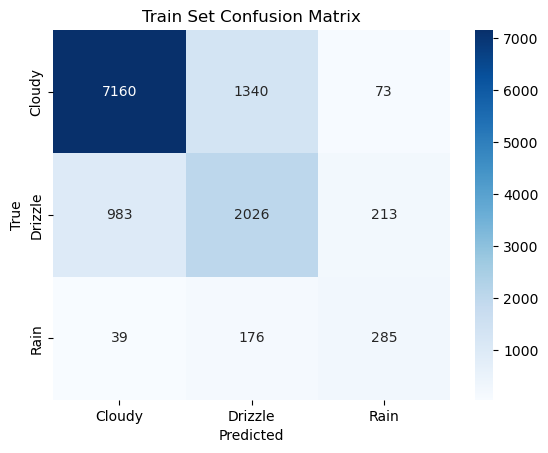


Validation Set Accuracy: 0.7313
              precision    recall  f1-score   support

      Cloudy       0.86      0.80      0.83      2442
     Drizzle       0.48      0.54      0.51       807
  Rain/Storm       0.51      0.65      0.57       264

    accuracy                           0.73      3513
   macro avg       0.62      0.66      0.64      3513
weighted avg       0.75      0.73      0.74      3513



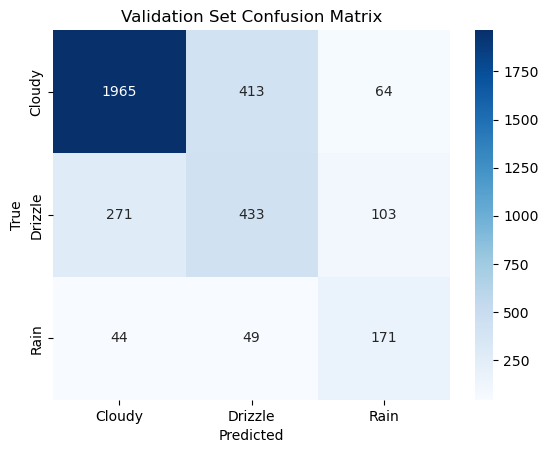


Test Set Accuracy: 0.6636
              precision    recall  f1-score   support

      Cloudy       0.81      0.51      0.63       654
     Drizzle       0.61      0.76      0.68       812
  Rain/Storm       0.64      0.74      0.69       291

    accuracy                           0.66      1757
   macro avg       0.69      0.67      0.66      1757
weighted avg       0.69      0.66      0.66      1757



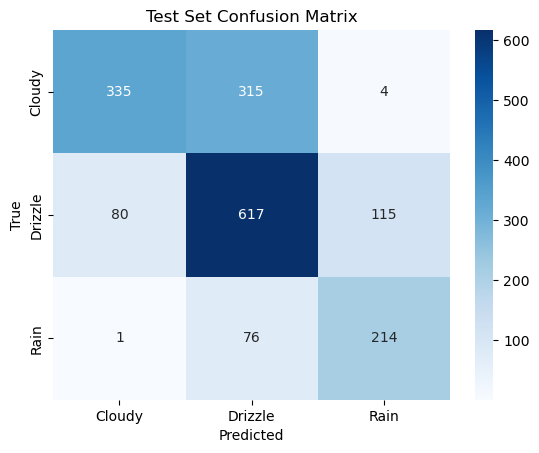

Model and preprocessing objects saved.


In [34]:
# 5. Đánh giá mô hình cuối cùng trên train, val và test
print("Evaluating Final Model on train, val and test sets...")
def evaluate_model(model, X, y, set_name="Set"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"\n{set_name} Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred, target_names=['Cloudy', 'Drizzle', 'Rain/Storm']))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Cloudy', 'Drizzle', 'Rain'], 
                yticklabels=['Cloudy', 'Drizzle', 'Rain'])
    plt.title(f'{set_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
evaluate_model(final_model, X_train_final, y_train, set_name="Train Set")
evaluate_model(final_model, X_val_final, y_val, set_name="Validation Set")
evaluate_model(final_model, X_test_final, y_test, set_name="Test Set")

# Lưu mô hình và các bước tiền xử lý nếu cần thiết
import joblib
joblib.dump(final_model, 'logistic_regression_weather_model.pkl')
joblib.dump(scaler, 'robust_scaler.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(poly, 'polynomial_features.pkl')
print("Model and preprocessing objects saved.")



--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH TOÀN DIỆN ---
Accuracy:       0.6636
Precision:      0.6891
Recall:         0.6636
F1-Score:       0.6600
Cohen's Kappa:  0.4534
------------------------------


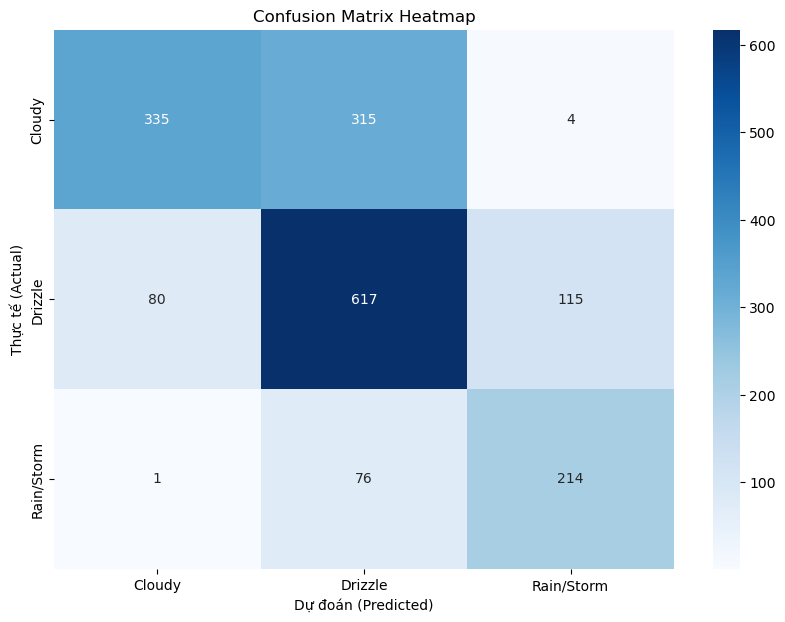

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# Giả định: 'y_test' và 'y_test_pred' đã có từ các bước trước

print("--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH TOÀN DIỆN ---")

# 1. Tính toán các chỉ số Numeric
acc = accuracy_score(y_test, y_test_pred)
# Weighted: Tính toán cho từng nhãn, và tìm giá trị trung bình theo số lượng mẫu của mỗi nhãn (Support)
prec = precision_score(y_test, y_test_pred, average='weighted')
rec = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"Cohen's Kappa:  {kappa:.4f}")
print("-" * 30)

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 7))

# Tạo nhãn rõ ràng (thay vì 0, 1, 2)
labels = ['Cloudy', 'Drizzle', 'Rain/Storm']
if len(cm) != len(labels): # Phòng trường hợp số lớp khác 3
    labels = None

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix Heatmap')
plt.show()